Proyecto de Series Temporales

         Objetivo: Estimar el número de ventas.

In [45]:
!pip install missingno lazypredict
!pip install statsmodels
!pip install pmdarima


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error


1. Carga del conjunto de datos.

In [47]:
# Descargo los datos base datos "sales":

# Leo los datos de la URL.
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"

# Guardo los datos en un DataFrame. La BD tiene 366 filas y 2 columnas.
df = pd.read_csv(url)

# Miro las variables de la bd.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [48]:
df.head()
#df.tail()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


2. Construye y analiza la serie temporal.

In [49]:
df.dtypes

date      object
sales    float64
dtype: object

In [50]:
df.isna().sum()

date     0
sales    0
dtype: int64

In [51]:
df.duplicated().sum()

np.int64(0)

No hay valores duplicados.

In [52]:
df.Date = pd.to_datetime(df.date)
df.dtypes

/tmp/ipykernel_740/3175655761.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Date = pd.to_datetime(df.date)


date      object
sales    float64
dtype: object

In [53]:
df.date.max()

'2023-09-03 17:10:08.079328'

In [54]:
df.date.min()

'2022-09-03 17:10:08.079328'

In [55]:
(df.Date.max()-df.Date.min()).days

365

Hay 365 días 

In [56]:
df.date.nunique()

366

No hay valores faltantes en las fechas.

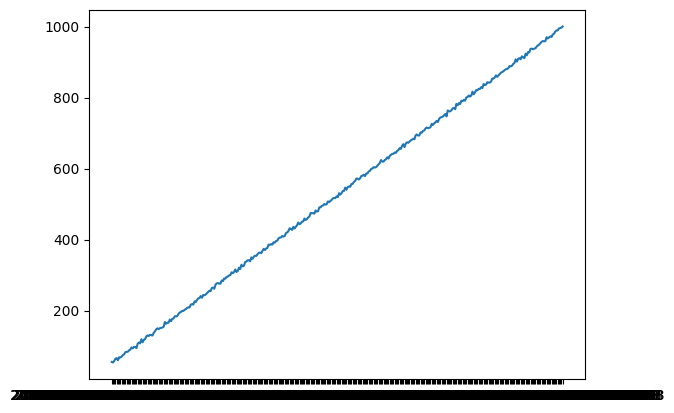

In [57]:
# Gráfico serie temporal
plt.plot(df.date, df.sales)

In [58]:
# Tensor de la serie temporal: Unidad de tiempo mínima para la cual hay datos.

# Calculo las diferencias de tiempo entre cada fila.
df['time_diff'] = df['date'].diff()

# Encuentro la diferencia mínima de tiempo (la unidad de tiempo mínima).
min_time_diff = df['time_diff'].min()

print("El tensor de la serie temporal (unidad mínima de tiempo) es:", min_time_diff)



TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
# Descomponer la serie temporal.
decomposition = seasonal_decompose(df.sales, period = 12)
decomposition


In [ ]:
# Tendencia.
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df.sales)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

La serie temporal tiene una tendencia ascendente.

In [ ]:
# Estacionalidad.
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df.sales)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [ ]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df.sales)

No podemos rechazar la H0. Por lo tanto, la serie es estacionaria.

In [ ]:
# Análisis variabilidad.
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df.sales)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

3. Modelo ARIMA.

Como la serie es estacionaria no tengo que transformarla.

Nota para Félix: He intentado instalar la librería pmdarima pero me da error. He intentado solventarlo de diferentes maneras, pero no lo he conseguido. Ante esta situación, he buscado librerías alternativas para poder estimar un modelo ARIMA.

In [65]:
# Preparo las variables
p = d = q = range(0, 3)  # Nota: Son los posibles valores para p, d, q 
pdq = list(itertools.product(p, d, q))  

# Defino una función para ajustar un modelo ARIMA con diferentes combinaciones y que devuelva el mejor modelo.
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    
    # Pronósticos.
    predictions = model_fit.forecast(steps=len(test))
    error = mean_squared_error(test, predictions)
    return error

# Pruebo todas las combinaciones de p, d, q. Guardo el mejor modelo.
best_score, best_cfg = float("inf"), None
for param in pdq:
    try:
        mse = evaluate_arima_model(df['sales'], param)
        if mse < best_score:
            best_score, best_cfg = mse, param
        print(f'ARIMA{param} MSE={mse}')
    except:
        continue

print(f'Mejor modelo ARIMA {best_cfg} con Mean Squared Error (MSE) igual a {best_score}')


ARIMA(0, 0, 0) MSE=229514.09848306564
ARIMA(0, 0, 1) MSE=227814.9727612115
ARIMA(0, 0, 2) MSE=227272.5298252427
ARIMA(0, 1, 0) MSE=12812.113627317478
ARIMA(0, 1, 1) MSE=12854.466716781824
ARIMA(0, 1, 2) MSE=13052.591218139389
ARIMA(0, 2, 0) MSE=339.77545784342624
ARIMA(0, 2, 1) MSE=11.476820738535444
ARIMA(0, 2, 2) MSE=30.09657499860414
ARIMA(1, 0, 0) MSE=13145.52993624097
ARIMA(1, 0, 1) MSE=13021.471107273519
ARIMA(1, 0, 2) MSE=13379.035597842101
ARIMA(1, 1, 0) MSE=12879.426821710964
ARIMA(1, 1, 1) MSE=16.492117306542024
ARIMA(1, 1, 2) MSE=28.838859426638656
ARIMA(1, 2, 0) MSE=8559.901482316778
ARIMA(1, 2, 1) MSE=11.43953259795855
ARIMA(1, 2, 2) MSE=7.965156531181016
ARIMA(2, 0, 0) MSE=13137.422985911784
ARIMA(2, 0, 1) MSE=13175.765754238124
ARIMA(2, 1, 0) MSE=12890.302930421765
ARIMA(2, 1, 1) MSE=12.710343246536675
ARIMA(2, 1, 2) MSE=8.87517168224903
ARIMA(2, 2, 0) MSE=6407.943847338072
ARIMA(2, 2, 1) MSE=8.277271391859117
ARIMA(2, 2, 2) MSE=7.981371306893933
Mejor modelo ARIMA(1, 2,

In [66]:
# Mdelo ARIMA con los mejores hiperparámetros calculados en el paso anterior.
model = ARIMA(df['sales'], order=best_cfg)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -919.511
Date:                Fri, 13 Sep 2024   AIC                           1847.023
Time:                        13:00:21   BIC                           1862.611
Sample:                             0   HQIC                          1853.218
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0890      0.052     -1.697      0.090      -0.192       0.014
ma.L1         -1.9313      0.552     -3.501      0.000      -3.013      -0.850
ma.L2          0.9313      0.513      1.816      0.0

4. Predicción del modelo con el conjunto test.

In [73]:
# Dividir los datos en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(df) * 0.8)
train, test = df['sales'][0:train_size], df['sales'][train_size:]

In [74]:
# Ajustar el modelo ARIMA con los mejores hiperparámetros
best_cfg = (1, 2, 2)  # Reemplaza con los mejores hiperparámetros que obtuviste
model = ARIMA(train, order=best_cfg)
model_fit = model.fit()

In [75]:
# Predecir los valores en el conjunto de prueba
forecast = model_fit.forecast(steps=len(test))

In [81]:
# Paso 3: Comparar las predicciones con los valores reales
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

MSE: 7.965156531181016
RMSE: 2.822260889992457
MAE: 2.2684943682546064


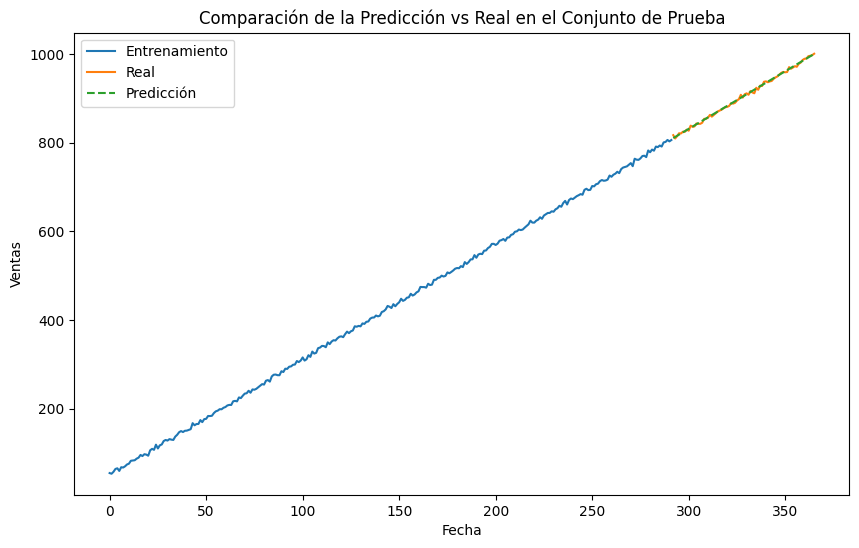

In [79]:
plt.figure(figsize=(10,6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Real')
plt.plot(test.index, forecast, label='Predicción', linestyle='--')
plt.title('Comparación de la Predicción vs Real en el Conjunto de Prueba')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()